# Derin Öğrenme ile COVID-19 Tespiti - Özge Çinko

Kaggle'dan aldığımız veriyi yükleyelim.

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 772M/778M [00:04<00:00, 126MB/s]
100% 778M/778M [00:04<00:00, 185MB/s]


In [6]:
! unzip covid19-radiography-database.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inf


<div style="width:100%;text-align: center;"> 
    <img align=middle src="https://upload.wikimedia.org/wikipedia/commons/7/72/Projectional_rendering_of_CT_scan_of_thorax_%28thumbnail%29.gif" alt="Heat beating" style="height:400px;margin-top:3rem;"> 
</div>

# [Veri Seti](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

# Kütüphanelerin Yüklenmesi

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Verinin Okunması
import os
from glob import glob
from PIL import Image

# Veri Önişleme
import numpy as np
import pandas as pd
import cv2
import random

# Veri Analizi
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modelleme
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
import keras


# Verilerin Okunması

In [8]:
levels = ['Normal/images', 'COVID/images']
path = "COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal/images': 'Negative', 'COVID/images': 'Positive'})
samples = 13808

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-485.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
1,Normal/images/Normal-4164.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
2,Normal/images/Normal-77.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
3,Normal/images/Normal-8400.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
4,Normal/images/Normal-3370.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...


In [9]:
print('Tekrarlanan Örnek Sayısı: %d'%(data.duplicated().sum()))
print('Toplam Örnek Sayısı: %d'%(data.isnull().value_counts()))

Tekrarlanan Örnek Sayısı: 0
Toplam Örnek Sayısı: 13808


In [10]:
data

,image_file,corona_result,path
0,Normal/images/Normal-485.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
1,Normal/images/Normal-4164.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
2,Normal/images/Normal-77.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
3,Normal/images/Normal-8400.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
4,Normal/images/Normal-3370.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...
...,...,...,...
13803,COVID/images/COVID-1733.png,Positive,COVID-19_Radiography_Dataset/COVID/images/COVI...
13804,COVID/images/COVID-1673.png,Positive,COVID-19_Radiography_Dataset/COVID/images/COVI...
13805,COVID/images/COVID-3300.png,Positive,COVID-19_Radiography_Dataset/COVID/images/COVI...
13806,COVID/images/COVID-3172.png,Positive,COVID-19_Radiography_Dataset/COVID/images/COVI...


# Keşifsel Veri Analizi

### 1. Sayı Grafiği

In [11]:
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

### 2. Görüntü Örnekleri

In [12]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()

,image_file,corona_result,path,image
0,Normal/images/Normal-485.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[0, 1, 18, 33, 47, 60, 70, 76, 71, 69, 120, 1..."
1,Normal/images/Normal-4164.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[0, 0, 9, 11, 10, 9, 9, 8, 8, 8, 8, 8, 8, 9, ..."
2,Normal/images/Normal-77.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[15, 24, 30, 36, 39, 38, 35, 29, 21, 13, 3, 0..."
3,Normal/images/Normal-8400.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[94, 104, 111, 124, 138, 141, 144, 157, 161, ..."
4,Normal/images/Normal-3370.png,Negative,COVID-19_Radiography_Dataset/Normal/images/Nor...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


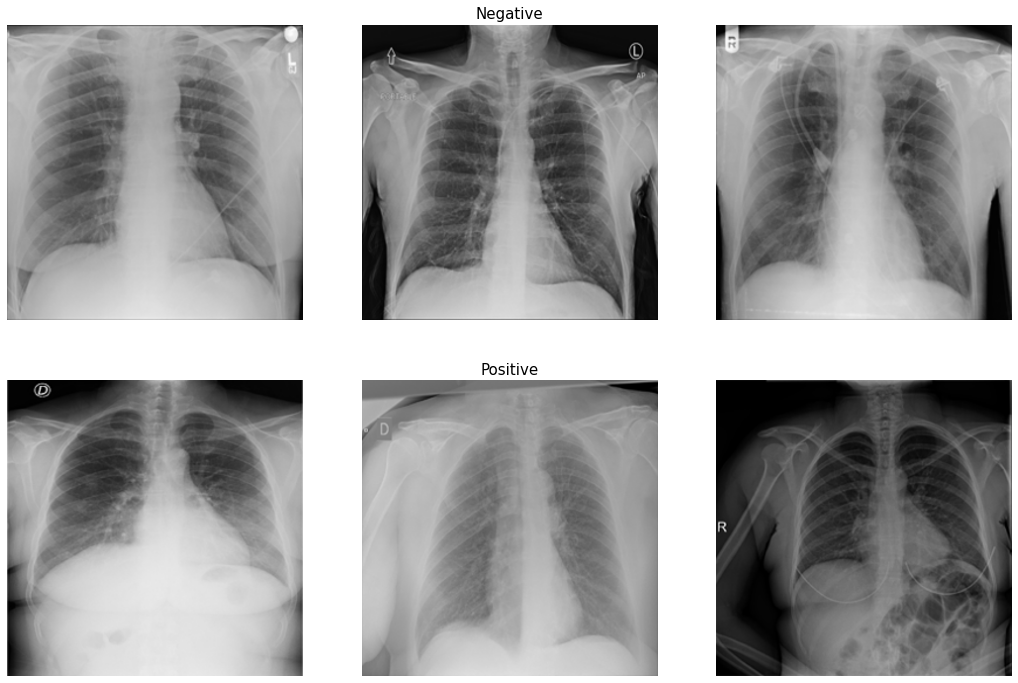

In [13]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

### 3. Rastgele Görüntü Analizi

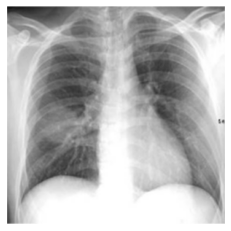

In [14]:
plt.figure()
image = cv2.imread("COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [15]:
print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 5


İncelenen görüntü bir X-Ray görüntüsüdür ancak 3 kanalı vardır, dolayısıyla bu görüntü RGB ölçeğindedir. Kısacası incelediğimiz görüntü bir X-Ray görüntüsü olsa bile RGB ölçeğindedir.


### 7. Görüntü Değer Dağılımı

In [16]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

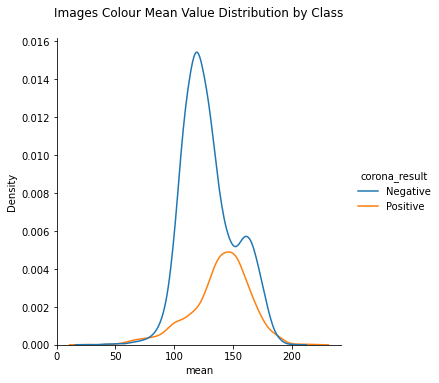

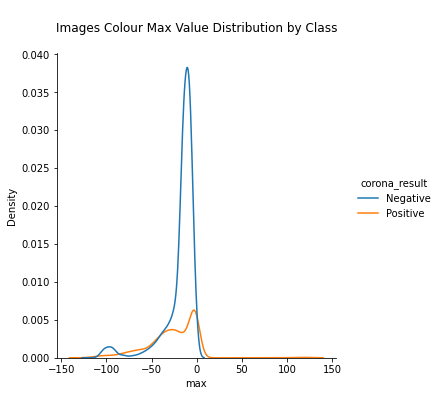

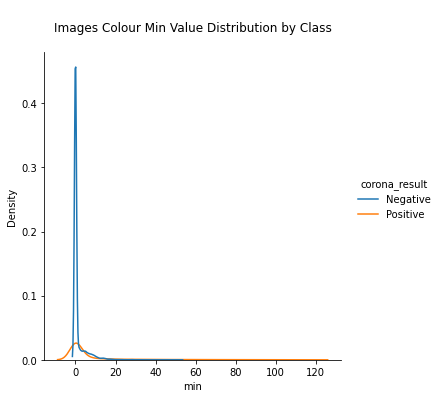

In [17]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'corona_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

Pikseller için Ortalama (Mean) - Yoğunluk (Density) grafiğinin açıklaması şu şekildedir:
* COVID-19 Negatif vakaları için maksimum piksel değeri 0,014'ten büyük ve 0,016'dan küçüktür.
* COVID-19 Pozitif vakaları için maksimum piksel değeri 0,004'ten büyük ve 0,006'dan küçüktür.

---

Pikseller için Maksimum - Yoğunluk (Density) grafiğinin açıklaması şu şekildedir:
* COVID-19 Negatif vakaları için maksimum piksel değeri 0,035'ten büyük ve 0,040'tan
küçüktür.
* COVID-19 Pozitif vakaları için maksimum piksel değeri 0,005'tir

---

Pikseller için Minimum - Yoğunluk (Density) grafiğinin açıklaması şu şekildedir:
* COVID-19 Negatif vakaları için maksimum piksel değeri 0,4'ten büyüktür.
* COVID-19 Pozitif vakaları için maksimum piksel değeri 0,0'dan büyük ve 0,1'den küçüktür.

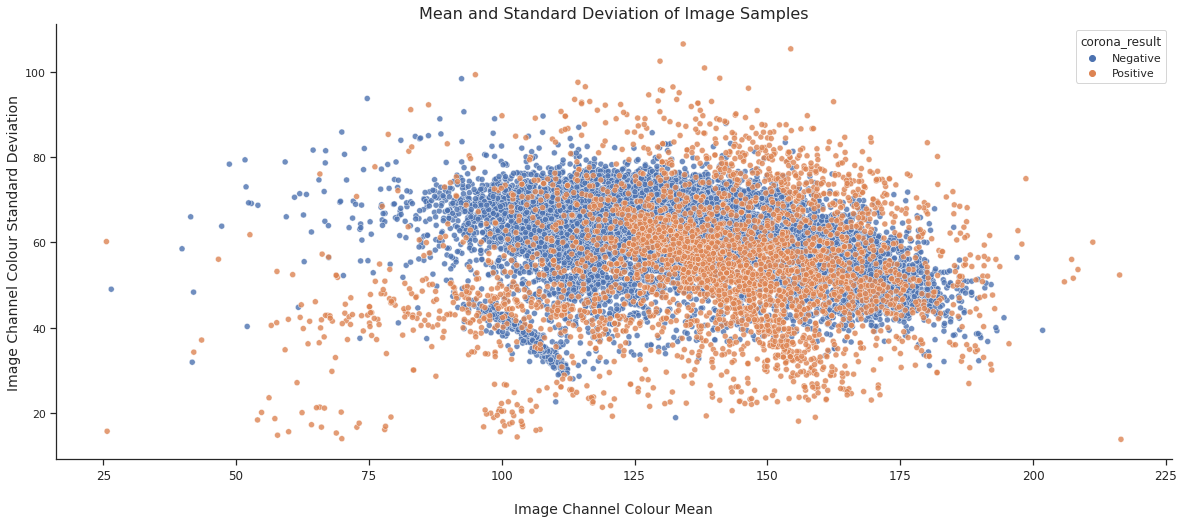

In [18]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'corona_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

Yukarıdaki grafikte görüldüğü üzere biri COVID-19 pozitif, biri COVID-19 negatif olmak üzere 2 küme oluştuğunu ve her iki kümede de birkaç örtüşmenin olduğunu gözlemleriz.

Örtüşen Renk Ortalama Aralığı: (100 - 175)

Standart sapması 30'un altında olan piksellerin hepsinin COVID-19 pozitif görüntüler (turuncu renkli) olduğunu gözlemleriz.

<Figure size 720x576 with 0 Axes>

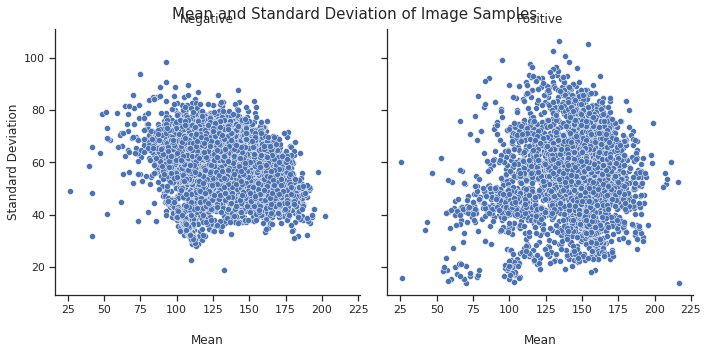

In [19]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "corona_result", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout();

Yukarıdaki grafikte görüldüğü üzere her iki dağılım grafiğini karşılaştırarak, pozitif örneklerin aykırı değerlere (piksel noktaları) sahip olduğunu gözlemleriz.

# Modelin Oluşturulması ve Eğitilmesi

### Train Test Split - Eğitim Test Ayrımı

In [20]:
all_data = []

# Train-Test ayrımı için görüntüleri ve etiketlerini bir listede saklarız.
for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [21]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# NumPy array'e dönüştürürüz.
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 70, 70, 3) (2762, 70, 70, 3) (1105, 70, 70, 3) (9941,) (2762,) (1105,)


### CNN Model

In [22]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 21s 244ms/step - loss: 0.6143 - accuracy: 0.7239 - val_loss: 0.5459 - val_accuracy: 0.7638
Epoch 2/50
39/39 [==============================] - 7s 191ms/step - loss: 0.5271 - accuracy: 0.7330 - val_loss: 0.4530 - val_accuracy: 0.7638
Epoch 3/50
39/39 [==============================] - 7s 190ms/step - loss: 0.4849 - accuracy: 0.7330 - val_loss: 0.4230 - val_accuracy: 0.7638
Epoch 4/50
39/39 [==============================] - 7s 190ms/step - loss: 0.4381 - accuracy: 0.7400 - val_loss: 0.3663 - val_accuracy: 0.8172
Epoch 5/50
39/39 [==============================] - 7s 190ms/step - loss: 0.3978 - accuracy: 0.8240 - val_loss: 0.3256 - val_accuracy: 0.8525
Epoch 6/50
39/39 [==============================] - 7s 190ms/step - loss: 0.3695 - accuracy: 0.8439 - val_loss: 0.3088 - val_accuracy: 0.9023
Epoch 7/50
39/39 [==============================] - 7s 189ms/step - loss: 0.3478 - accuracy: 0.8623 - val_loss: 0.2837 - val_accuracy: 0.8941
Epoch

In [24]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

### Modelin Değerlendirilmesi

In [25]:
def evaluation(name, x, y):
    
    print("\n--------------------Evaluation Results for {} Data-----------------------\n".format(name))
    
    cm = confusion_matrix(x, y)
    confusion = ConfusionMatrixDisplay(cm)
    specificity = round((cm[0,0]/(cm[0,0] + cm[0,1])),4)
    
    print("Classification Report for {} Data\n".format(name))
    print(classification_report(x, y)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Data: ", round(recall_score(x, y),4))
    print("Specificity on Data: ", specificity)
    print("Accuracy on Data: ", round(accuracy_score(x, y),4))
    print("Precision on Data: ", round(precision_score(x, y),4))
    print("F1 Score on Data: ", round(f1_score(x, y),4))
    print("--------------------------------------------------------------------------")
    
    print("Confusion Matrix for {} Data\n".format(name))
    confusion.plot()


--------------------Evaluation Results for Train Data-----------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7287
           1       0.94      0.99      0.97      2654

    accuracy                           0.98      9941
   macro avg       0.97      0.99      0.98      9941
weighted avg       0.98      0.98      0.98      9941

--------------------------------------------------------------------------
Recall on Data:  0.994
Specificity on Data:  0.978
Accuracy on Data:  0.9823
Precision on Data:  0.9428
F1 Score on Data:  0.9677
--------------------------------------------------------------------------
Confusion Matrix for Train Data



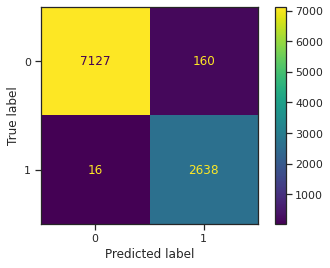

In [26]:
evaluation("Train", y_train, yp_train)


--------------------Evaluation Results for Validation Data-----------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       844
           1       0.88      0.94      0.91       261

    accuracy                           0.96      1105
   macro avg       0.93      0.95      0.94      1105
weighted avg       0.96      0.96      0.96      1105

--------------------------------------------------------------------------
Recall on Data:  0.9425
Specificity on Data:  0.9597
Accuracy on Data:  0.9557
Precision on Data:  0.8786
F1 Score on Data:  0.9094
--------------------------------------------------------------------------
Confusion Matrix for Validation Data



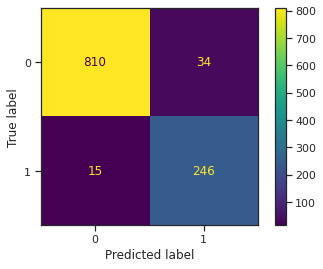

In [27]:
evaluation("Validation", y_val, yp_val)


--------------------Evaluation Results for Test Data-----------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2061
           1       0.90      0.95      0.93       701

    accuracy                           0.96      2762
   macro avg       0.94      0.96      0.95      2762
weighted avg       0.96      0.96      0.96      2762

--------------------------------------------------------------------------
Recall on Data:  0.9544
Specificity on Data:  0.9641
Accuracy on Data:  0.9616
Precision on Data:  0.9004
F1 Score on Data:  0.9266
--------------------------------------------------------------------------
Confusion Matrix for Test Data



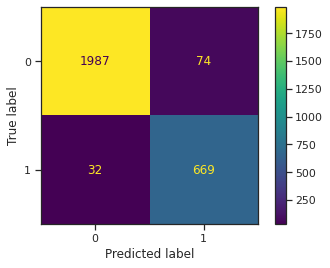

In [28]:
evaluation("Test", y_test, yp_test)

In [29]:
# Tüm metrikleri listeleyelim.
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


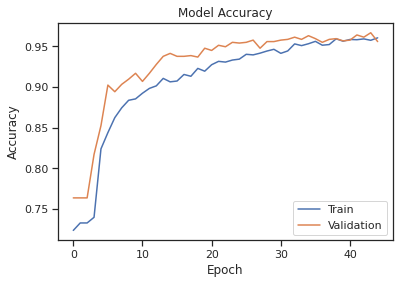

In [30]:
# Doğruluk (Accuracy) Grafiği

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

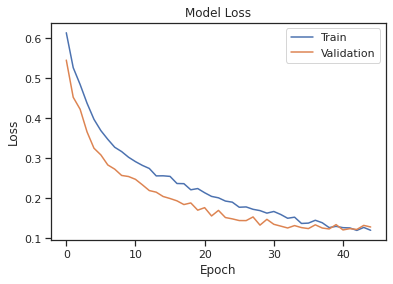

In [31]:
# Kayıp (Loss) Grafiği

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

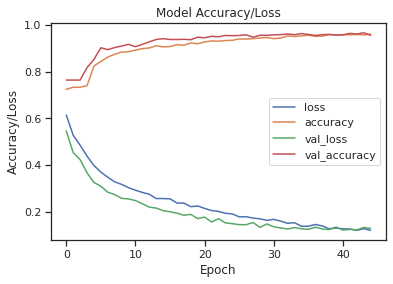

In [32]:
# Accuracy - Loss Grafiği

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

# Modelin Kaydedilmesi

In [33]:
cnn_model.save('cnn_model.h5')